In [1]:
%%time
import sys
sys.path.insert(0, '/Users/shuyafeng/PycharmProjects/xiaozaizi/codes/')

import os
import json
import warnings
import pprint


%reload_ext autoreload
%autoreload
%autoreload 2
%config Completer.use_jedi = False

CPU times: user 16 ms, sys: 15.4 ms, total: 31.4 ms
Wall time: 43.7 ms


In [77]:
import numpy as np
import scipy.io
from numpy.random import choice, laplace
from scipy.special import lambertw
from scipy.stats import laplace
from codes.kse_test import kse_test
from codes.dbscan import dbscan
import pandas as pd


In [397]:
dataset4 = scipy.io.loadmat('/Users/shuyafeng/PycharmProjects/xiaozaizi/4.mat')['dataset4']
sizeofD = 100
dataset2 = dataset4[:, :3]
S, _ = np.histogram(dataset2, bins=sizeofD)
eps = [0.5,1,2,3,4,5,6,7,8,9,10]
B = S.reshape(-1, 1)
C = B[:sizeofD]

Output = dbscan(C)

pp = 1. / (Output ** 5)
pp = pp.reshape(-1)
pp /= pp.sum()
NN = 2 ** (15 * Output)
px = np.arange(1, sizeofD+1)

gamma = 0.5
rho = np.exp(lambertw(-gamma / (2 * np.exp(0.5)), k=-1) + 0.5)
rho = np.real(rho)
m = np.log(1 / rho) / (2 * (gamma - rho) ** 2)
k = m * (1 - gamma + rho + np.sqrt(np.log(1 / rho) / (2 * m)))
m = int(float(np.ceil(m)))
k = int(float(np.ceil(k)))


In [398]:
Output

array([0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,
       0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,
       0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,
       0.9, 0.9, 0.9, 0.9, 0.7, 0.7, 0.9, 0.7, 0.7, 0.9, 0.9, 0.9, 0.9,
       0.9, 0.7, 0.7, 0.9, 0.7, 0.7, 0.7, 0.7, 0.9, 0.7, 0.9, 0.7, 0.7,
       0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7,
       0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7,
       0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7])

In [405]:
#EVAL = np.zeros((4, 7))
EVAL = np.zeros((len(eps), 7))

for rr in range(len(eps)):
    for j in range(1):
        C = B[:sizeofD].reshape(-1)
        GS = np.sort(np.random.choice(C, size=m, replace=False))
        Sensunif = GS[k-1]
        SS = np.sort(np.random.choice(px, size=m, replace=True, p=pp))
        SS = NN[np.floor(SS).astype(int)]
        SS = np.sort(SS)
        Sensanom = SS[k-1]
        C= B[:sizeofD]
        #unif = laplace.rvs(loc=0, scale=Sensunif/(eps[rr]), size=sizeofD) + C
        unif=C
        unif=[i + laplace.rvs(loc=0, scale=Sensunif/(eps[rr]),size=1) for i in unif]

        #noiseanom = laplace.rvs(loc=0, scale=Sensanom/(eps[rr]), size=sizeofD) + NN
        noiseanom = NN
        noiseanom=[i + laplace.rvs(loc=0, scale=Sensanom/(eps[rr]),size=1) for i in noiseanom]
        
        
        noiseunif = dbscan(unif)
        noiseanom = dbscan(noiseanom)

        Index = np.zeros((sizeofD, 2))
        Index[:, 0] = np.arange(1, sizeofD+1)

        for i in range(sizeofD):
            if Output[i] > 0.8:
                Index[i, 1] = 1

        ACTUAL = Index
        Origindex = np.where(ACTUAL[:, 1] == 1)[0]

        Index = np.zeros((sizeofD, 2))
        Index[:, 0] = np.arange(1, sizeofD+1)

        for i in range(sizeofD):
            if noiseunif[i] > 0.8:
                Index[i, 1] = 1

        Uniformm = Index
        Pertindex = np.where(Uniformm[:, 1] == 1)[0]

        Index = np.zeros((sizeofD, 2))
        Index[:, 0] = np.arange(1, sizeofD+1)

        for i in range(sizeofD):
            if noiseanom[i] > 0.8:
                Index[i, 1] = 1

        Anomm = Index
        Pertindex1 = np.where(Anomm[:, 1] == 1)[0]
        IND1 = Anomm
        IND = Uniformm

        C = len(set(Origindex) | set(Pertindex))
        p = len(Origindex)
        n = sizeofD - p
        N = p + n
        tp = sum(ACTUAL[Origindex, 1] == IND[Origindex, 1])
        tn = N - C
        fp = n - tn
        fn = p - tp
        tp_rate = tp / p
        tn_rate = tn / n
        accuracy = (tp + tn) / N
        sensitivity = tp_rate
        specificity = tn_rate
        precision = tp / (tp + fp)
        recall = sensitivity
        f_measure = 2 * ((precision * recall) / (precision + recall))
        gmean = np.sqrt(tp_rate * tn)
        EVAL[rr, :] += np.array([accuracy, tp, specificity, precision, recall, f_measure, gmean])



In [402]:
#dataset4 = scipy.io.loadmat('/Users/shuyafeng/PycharmProjects/xiaozaizi/server1.mat')['dataset4']
dataset4 = np.array(pd.read_csv('tr_server_data.csv'))
sizeofD = 100
dataset2 = dataset4[:, :1]
S, _ = np.histogram(dataset2, bins=sizeofD)
eps = [0.5,1,2,3,4,5,6,7,8,9,10]
B = S.reshape(-1, 1)
C = B[:sizeofD]
Output = dbscan(C)

pp = 1. / (Output ** 5)
pp = pp.reshape(-1)
pp /= pp.sum()
NN = 2 ** (15 * Output)
px = np.arange(1, sizeofD+1)

gamma = 0.5
rho = np.exp(lambertw(-gamma / (2 * np.exp(0.5)), k=-1) + 0.5)
rho = np.real(rho)
m = np.log(1 / rho) / (2 * (gamma - rho) ** 2)
k = m * (1 - gamma + rho + np.sqrt(np.log(1 / rho) / (2 * m)))
m = int(float(np.ceil(m)))
k = int(float(np.ceil(k)))


In [261]:
Output

array([0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7,
       0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7,
       0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.9, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7,
       0.9, 0.9, 0.9, 0.7, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.7, 0.9, 0.7,
       0.7, 0.9, 0.9, 0.7, 0.9, 0.7, 0.7, 0.9, 0.9, 0.9, 0.7, 0.7, 0.7,
       0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7,
       0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7,
       0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7])

In [361]:
#EVAL = np.zeros((4, 7))
EVAL1 = np.zeros((len(eps), 7))

for rr in range(len(eps)):
    for j in range(1):
        C = B[:sizeofD].reshape(-1)
        GS = np.sort(np.random.choice(C, size=m, replace=False))
        Sensunif = GS[k-1]
        SS = np.sort(np.random.choice(px, size=m, replace=True, p=pp))
        SS = NN[np.floor(SS).astype(int)]
        SS = np.sort(SS)
        Sensanom = SS[k-1]

        C= B[:sizeofD]
        #unif = laplace.rvs(loc=0, scale=Sensunif/(eps[rr]), size=sizeofD) + C
        unif=C
        unif=[i + laplace.rvs(loc=0, scale=Sensunif/(eps[rr]),size=1) for i in unif]

        #noiseanom = laplace.rvs(loc=0, scale=Sensanom/(eps[rr]), size=sizeofD) + NN
        noiseanom = NN
        noiseanom=[i + laplace.rvs(loc=0, scale=Sensanom/(eps[rr]),size=1) for i in noiseanom]
        

        noiseunif = dbscan(unif)
        noiseanom = dbscan(noiseanom)

        Index = np.zeros((sizeofD, 2))
        Index[:, 0] = np.arange(1, sizeofD+1)

        for i in range(sizeofD):
            if Output[i] > 0.8:
                Index[i, 1] = 1

        ACTUAL = Index
        Origindex = np.where(ACTUAL[:, 1] == 1)[0]

        Index = np.zeros((sizeofD, 2))
        Index[:, 0] = np.arange(1, sizeofD+1)

        for i in range(sizeofD):
            if noiseunif[i] > 0.8:
                Index[i, 1] = 1

        Uniformm = Index
        Pertindex = np.where(Uniformm[:, 1] == 1)[0]

        Index = np.zeros((sizeofD, 2))
        Index[:, 0] = np.arange(1, sizeofD+1)

        for i in range(sizeofD):
            if noiseanom[i] > 0.8:
                Index[i, 1] = 1

        Anomm = Index
        Pertindex1 = np.where(Anomm[:, 1] == 1)[0]
        IND1 = Anomm
        IND = Uniformm

        C = len(set(Origindex) | set(Pertindex))
        p = len(Origindex)
        n = sizeofD - p
        N = p + n
        tp = sum(ACTUAL[Origindex, 1] == IND[Origindex, 1])
        tn = N - C
        fp = n - tn
        fn = p - tp
        tp_rate = tp / p
        tn_rate = tn / n
        accuracy = (tp + tn) / N
        sensitivity = tp_rate
        specificity = tn_rate
        precision = tp / (tp + fp)
        recall = sensitivity
        f_measure = 2 * ((precision * recall) / (precision + recall))
        gmean = np.sqrt(tp_rate * tn)
        EVAL1[rr, :] += np.array([accuracy, tp, specificity, precision, recall, f_measure, gmean])



## baseline

In [443]:
dataset4 = scipy.io.loadmat('/Users/shuyafeng/PycharmProjects/xiaozaizi/4.mat')['dataset4']
#dataset4 = np.array(pd.read_csv('tr_server_data.csv'))
sizeofD = 100
dataset2 = dataset4[:, :1]
S, _ = np.histogram(dataset2, bins=sizeofD)
eps = [0.5,1,2,3,4,5,6,7,8,9,10]
B = S.reshape(-1, 1)
C = B[:sizeofD]
Output = dbscan(C)

pp = 1. / (Output ** 5)
pp = pp.reshape(-1)
pp /= pp.sum()
NN = 2 ** (15 * Output)
px = np.arange(1, sizeofD+1)

gamma = 0.5
rho = np.exp(lambertw(-gamma / (2 * np.exp(0.5)), k=-1) + 0.5)
rho = np.real(rho)
m = np.log(1 / rho) / (2 * (gamma - rho) ** 2)
k = m * (1 - gamma + rho + np.sqrt(np.log(1 / rho) / (2 * m)))
m = int(float(np.ceil(m)))
k = int(float(np.ceil(k)))


In [444]:
#EVAL = np.zeros((4, 7))
EVAL2 = np.zeros((len(eps), 7))

for rr in range(len(eps)):
    for j in range(1):
        C = B[:sizeofD].reshape(-1)
        
        GS = np.sort(np.random.choice(C, size=m, replace=False))
        Sensunif = GS[k-1]
        SS = np.sort(np.random.choice(px, size=m, replace=False))
        SS = NN[np.floor(SS).astype(int)]
        SS = np.sort(SS)
        Sensanom = SS[k-1]

        C= B[:sizeofD]
        #unif = laplace.rvs(loc=0, scale=Sensunif/(eps[rr]), size=sizeofD) + C
        unif=C
        unif=[i + laplace.rvs(loc=0, scale=Sensunif/(eps[rr]),size=1) for i in unif]

        #noiseanom = laplace.rvs(loc=0, scale=Sensanom/(eps[rr]), size=sizeofD) + NN
        noiseanom = NN
        noiseanom=[i + laplace.rvs(loc=0, scale=Sensanom/(eps[rr]),size=1) for i in noiseanom]
        

        noiseunif = dbscan(unif)
        noiseanom = dbscan(noiseanom)

        Index = np.zeros((sizeofD, 2))
        Index[:, 0] = np.arange(1, sizeofD+1)

        for i in range(sizeofD):
            if Output[i] > 0.8:
                Index[i, 1] = 1

        ACTUAL = Index
        Origindex = np.where(ACTUAL[:, 1] == 1)[0]

        Index = np.zeros((sizeofD, 2))
        Index[:, 0] = np.arange(1, sizeofD+1)

        for i in range(sizeofD):
            if noiseunif[i] > 0.8:
                Index[i, 1] = 1

        Uniformm = Index
        Pertindex = np.where(Uniformm[:, 1] == 1)[0]

        Index = np.zeros((sizeofD, 2))
        Index[:, 0] = np.arange(1, sizeofD+1)

        for i in range(sizeofD):
            if noiseanom[i] > 0.8:
                Index[i, 1] = 1

        Anomm = Index
        Pertindex1 = np.where(Anomm[:, 1] == 1)[0]
        IND1 = Anomm
        IND = Uniformm

        C = len(set(Origindex) | set(Pertindex))
        p = len(Origindex)
        n = sizeofD - p
        N = p + n
        tp = sum(ACTUAL[Origindex, 1] == IND[Origindex, 1])
        tn = N - C
        fp = n - tn
        fn = p - tp
        tp_rate = tp / p
        tn_rate = tn / n
        accuracy = (tp + tn) / N
        sensitivity = tp_rate
        specificity = tn_rate
        precision = tp / (tp + fp)
        recall = sensitivity
        f_measure = 2 * ((precision * recall) / (precision + recall))
        gmean = np.sqrt(tp_rate * tn)
        EVAL2[rr, :] += np.array([accuracy, tp, specificity, precision, recall, f_measure, gmean])



In [423]:
#dataset4 = scipy.io.loadmat('/Users/shuyafeng/PycharmProjects/xiaozaizi/server1.mat')['dataset4']
dataset4 = np.array(pd.read_csv('tr_server_data.csv'))
sizeofD = 100
dataset2 = dataset4[:, :1]
S, _ = np.histogram(dataset2, bins=sizeofD)
eps = [0.5,1,2,3,4,5,6,7,8,9,10]
B = S.reshape(-1, 1)
C = B[:sizeofD]
Output = dbscan(C)

pp = 1. / (Output ** 5)
pp = pp.reshape(-1)
pp /= pp.sum()
NN = 2 ** (15 * Output)
px = np.arange(1, sizeofD+1)

gamma = 0.5
rho = np.exp(lambertw(-gamma / (2 * np.exp(0.5)), k=-1) + 0.5)
rho = np.real(rho)
m = np.log(1 / rho) / (2 * (gamma - rho) ** 2)
k = m * (1 - gamma + rho + np.sqrt(np.log(1 / rho) / (2 * m)))
m = int(float(np.ceil(m)))
k = int(float(np.ceil(k)))


In [424]:
Sensunif

825

In [425]:
#EVAL = np.zeros((4, 7))
EVAL3 = np.zeros((len(eps), 7))

for rr in range(len(eps)):
    for j in range(1):
        C = B[:sizeofD].reshape(-1)
        
        GS = np.sort(np.random.choice(C, size=m, replace=False))
        Sensunif = GS[k-1]
        SS = np.sort(np.random.choice(px, size=m, replace=False))
        SS = NN[np.floor(SS).astype(int)]
        SS = np.sort(SS)
        Sensanom = SS[k-1]

        C= B[:sizeofD]
        #unif = laplace.rvs(loc=0, scale=Sensunif/(eps[rr]), size=sizeofD) + C
        unif=C
        unif=[i + laplace.rvs(loc=0, scale=Sensunif/(eps[rr]),size=1) for i in unif]

        #noiseanom = laplace.rvs(loc=0, scale=Sensanom/(eps[rr]), size=sizeofD) + NN
        noiseanom = NN
        noiseanom=[i + laplace.rvs(loc=0, scale=Sensanom/(eps[rr]),size=1) for i in noiseanom]
        

        noiseunif = dbscan(unif)
        noiseanom = dbscan(noiseanom)

        Index = np.zeros((sizeofD, 2))
        Index[:, 0] = np.arange(1, sizeofD+1)

        for i in range(sizeofD):
            if Output[i] > 0.8:
                Index[i, 1] = 1

        ACTUAL = Index
        Origindex = np.where(ACTUAL[:, 1] == 1)[0]

        Index = np.zeros((sizeofD, 2))
        Index[:, 0] = np.arange(1, sizeofD+1)

        for i in range(sizeofD):
            if noiseunif[i] > 0.8:
                Index[i, 1] = 1

        Uniformm = Index
        Pertindex = np.where(Uniformm[:, 1] == 1)[0]

        Index = np.zeros((sizeofD, 2))
        Index[:, 0] = np.arange(1, sizeofD+1)

        for i in range(sizeofD):
            if noiseanom[i] > 0.8:
                Index[i, 1] = 1

        Anomm = Index
        Pertindex1 = np.where(Anomm[:, 1] == 1)[0]
        IND1 = Anomm
        IND = Uniformm

        C = len(set(Origindex) | set(Pertindex))
        p = len(Origindex)
        n = sizeofD - p
        N = p + n
        tp = sum(ACTUAL[Origindex, 1] == IND[Origindex, 1])
        tn = N - C
        fp = n - tn
        fn = p - tp
        tp_rate = tp / p
        tn_rate = tn / n
        accuracy = (tp + tn) / N
        sensitivity = tp_rate
        specificity = tn_rate
        precision = tp / (tp + fp)
        recall = sensitivity
        f_measure = 2 * ((precision * recall) / (precision + recall))
        gmean = np.sqrt(tp_rate * tn)
        EVAL3[rr, :] += np.array([accuracy, tp, specificity, precision, recall, f_measure, gmean])



In [277]:
pd.DataFrame(EVAL1, columns=["accuracy", "tp", "specificity", "precision", "recall", "f_measure", "gmean"])

,accuracy,tp,specificity,precision,recall,f_measure,gmean
0,0.64,10.0,0.650602,0.256410,0.588235,0.357143,5.636019
1,0.46,13.0,0.397590,0.206349,0.764706,0.325000,5.023474
2,0.60,5.0,0.662651,0.151515,0.294118,0.200000,4.021998
3,0.92,13.0,0.951807,0.764706,0.764706,0.764706,7.772501
4,0.84,8.0,0.915663,0.533333,0.470588,0.500000,5.980360
5,0.73,6.0,0.807229,0.272727,0.352941,0.307692,4.862824
6,0.97,14.0,1.000000,1.000000,0.823529,0.903226,8.267584
7,0.78,7.0,0.855422,0.368421,0.411765,0.388889,5.406967
8,1.00,17.0,1.000000,1.000000,1.000000,1.000000,9.110434
9,0.86,11.0,0.903614,0.578947,0.647059,0.611111,6.966305


In [406]:
pd.DataFrame(EVAL, columns=["accuracy", "tp", "specificity", "precision", "recall", "f_measure", "gmean"])

,accuracy,tp,specificity,precision,recall,f_measure,gmean
0,0.44,3.0,0.450549,0.056604,0.333333,0.096774,3.696846
1,0.71,2.0,0.758242,0.083333,0.222222,0.121212,3.915780
2,0.69,3.0,0.725275,0.107143,0.333333,0.162162,4.690416
3,0.88,4.0,0.923077,0.363636,0.444444,0.400000,6.110101
4,0.85,2.0,0.912088,0.200000,0.222222,0.210526,4.294700
5,0.88,4.0,0.923077,0.363636,0.444444,0.400000,6.110101
6,0.84,4.0,0.879121,0.266667,0.444444,0.333333,5.962848
7,0.81,1.0,0.879121,0.083333,0.111111,0.095238,2.981424
8,0.87,4.0,0.912088,0.333333,0.444444,0.380952,6.073622
9,0.87,1.0,0.945055,0.166667,0.111111,0.133333,3.091206


In [445]:
pd.DataFrame(EVAL2, columns=["accuracy", "tp", "specificity", "precision", "recall", "f_measure", "gmean"])

,accuracy,tp,specificity,precision,recall,f_measure,gmean
0,0.49,48.0,0.019608,0.489796,0.979592,0.653061,0.989743
1,0.51,48.0,0.058824,0.500000,0.979592,0.662069,1.714286
2,0.47,45.0,0.039216,0.478723,0.918367,0.629371,1.355262
3,0.51,45.0,0.117647,0.500000,0.918367,0.647482,2.347382
4,0.51,48.0,0.058824,0.500000,0.979592,0.662069,1.714286
5,0.51,48.0,0.058824,0.500000,0.979592,0.662069,1.714286
6,0.55,48.0,0.137255,0.521739,0.979592,0.680851,2.618615
7,0.47,46.0,0.019608,0.479167,0.938776,0.634483,0.968904
8,0.55,43.0,0.235294,0.524390,0.877551,0.656489,3.245090
9,0.55,47.0,0.156863,0.522222,0.959184,0.676259,2.770103


In [427]:
pd.DataFrame(EVAL3, columns=["accuracy", "tp", "specificity", "precision", "recall", "f_measure", "gmean"])

,accuracy,tp,specificity,precision,recall,f_measure,gmean
0,0.29,5.0,0.263736,0.069444,0.555556,0.123457,3.651484
1,0.60,4.0,0.615385,0.102564,0.444444,0.166667,4.988877
2,0.76,4.0,0.791209,0.173913,0.444444,0.250000,5.656854
3,0.81,4.0,0.846154,0.222222,0.444444,0.296296,5.849976
4,0.80,3.0,0.846154,0.176471,0.333333,0.230769,5.066228
5,0.84,2.0,0.901099,0.181818,0.222222,0.200000,4.268749
6,0.85,2.0,0.912088,0.200000,0.222222,0.210526,4.294700
7,0.94,6.0,0.967033,0.666667,0.666667,0.666667,7.659417
8,0.92,7.0,0.934066,0.538462,0.777778,0.636364,8.130874
9,0.83,2.0,0.890110,0.166667,0.222222,0.190476,4.242641


In [ ]:
mm2=

In [441]:
m=pd.DataFrame(EVAL, columns=["accuracy", "tp", "specificity", "precision", "recall", "f_measure", "gmean"])

In [377]:
m1=pd.DataFrame(EVAL1, columns=["accuracy", "tp", "specificity", "precision", "recall", "f_measure", "gmean"])

In [438]:
m2=pd.DataFrame(EVAL2, columns=["accuracy", "tp", "specificity", "precision", "recall", "f_measure", "gmean"])

In [439]:
m3=pd.DataFrame(EVAL3, columns=["accuracy", "tp", "specificity", "precision", "recall", "f_measure", "gmean"])

In [442]:
to_save=[m['accuracy'],m['precision'],m['recall'],m['f_measure'],m1['accuracy'],m1['precision'],m1['recall'],m1['f_measure'],m2['accuracy'],m2['precision'],m2['recall'],m2['f_measure'],m3['accuracy'],m3['precision'],m3['recall'],m3['f_measure']]
to_save=pd.DataFrame(to_save).T
to_save.columns=['accuracy','precision','recall','f_measure','accuracy1','precision1','recall1','f_measure1','accuracy2','precision2','recall2','f_measure2','accuracy3','precision3','recall3','f_measure3']
to_save.to_csv('dbscan1.csv', index=False)


In [364]:
read_dbscan=pd.read_csv('dbscan.csv')
read_dbscan

,accuracy,precision,recall,f_measure,accuracy1,precision1,recall1,f_measure1,accuracy2,precision2,recall2,f_measure2,accuracy3,precision3,recall3,f_measure3
0,0.54,0.531915,0.961538,0.684932,0.64,0.256410,0.588235,0.357143,0.51,0.500000,1.000000,0.666667,0.63,0.062500,0.222222,0.097561
1,0.50,0.510417,0.942308,0.662162,0.46,0.206349,0.764706,0.325000,0.49,0.490000,1.000000,0.657718,1.00,1.000000,1.000000,1.000000
2,0.54,0.531250,0.980769,0.689189,0.60,0.151515,0.294118,0.200000,0.53,0.510638,0.979592,0.671329,0.67,0.038462,0.111111,0.057143
3,0.57,0.548387,0.980769,0.703448,0.92,0.764706,0.764706,0.764706,0.47,0.478723,0.918367,0.629371,0.86,0.307692,0.444444,0.363636
4,0.51,0.515789,0.942308,0.666667,0.84,0.533333,0.470588,0.500000,0.49,0.489796,0.979592,0.653061,0.85,0.200000,0.222222,0.210526
5,0.52,0.520000,1.000000,0.684211,0.73,0.272727,0.352941,0.307692,0.49,0.489796,0.979592,0.653061,0.91,0.500000,0.666667,0.571429
6,0.58,0.556818,0.942308,0.700000,0.97,1.000000,0.823529,0.903226,0.75,0.671429,0.959184,0.789916,0.84,0.230769,0.333333,0.272727
7,0.53,0.528090,0.903846,0.666667,0.78,0.368421,0.411765,0.388889,0.54,0.516484,0.959184,0.671429,0.90,0.444444,0.444444,0.444444
8,0.52,0.521277,0.942308,0.671233,1.00,1.000000,1.000000,1.000000,0.58,0.539326,0.979592,0.695652,0.87,0.300000,0.333333,0.315789
9,0.54,0.534884,0.884615,0.666667,0.86,0.578947,0.647059,0.611111,0.53,0.511111,0.938776,0.661871,0.92,0.571429,0.444444,0.500000


In [119]:
read_svm=pd.read_csv('svm.csv')
read_svm

,accuracy,precision,recall,f_measure,accuracy1,precision1,recall1,f_measure1
0,0.64,0.466667,0.411765,0.437500,0.45,0.309091,0.500000,0.382022
1,0.46,0.348485,0.676471,0.460000,0.56,0.380952,0.470588,0.421053
2,0.49,0.282051,0.323529,0.301370,0.38,0.325000,0.764706,0.456140
3,0.48,0.354839,0.647059,0.458333,0.58,0.409091,0.529412,0.461538
4,0.50,0.333333,0.470588,0.390244,0.54,0.375000,0.529412,0.439024
5,0.53,0.361702,0.500000,0.419753,0.47,0.288889,0.382353,0.329114
6,0.58,0.423077,0.647059,0.511628,0.56,0.368421,0.411765,0.388889
7,0.61,0.439024,0.529412,0.480000,0.52,0.281250,0.264706,0.272727
8,0.50,0.318182,0.411765,0.358974,0.50,0.340000,0.500000,0.404762
9,0.53,0.348837,0.441176,0.389610,0.58,0.394737,0.441176,0.416667


In [120]:
read_tree=pd.read_csv('tree.csv')
read_tree

,accuracy,precision,recall,f_measure,accuracy1,precision1,recall1,f_measure1
0,0.59,0.105263,0.076923,0.088889,0.59,0.105263,0.076923,0.088889
1,0.65,0.263158,0.192308,0.222222,0.68,0.350000,0.269231,0.304348
2,0.94,0.857143,0.923077,0.888889,0.68,0.350000,0.269231,0.304348
3,0.76,0.529412,0.692308,0.600000,0.69,0.400000,0.384615,0.392157
4,0.77,0.588235,0.384615,0.465116,0.71,0.444444,0.461538,0.452830
5,0.73,0.480000,0.461538,0.470588,0.81,0.652174,0.576923,0.612245
6,0.81,0.652174,0.576923,0.612245,0.81,0.606061,0.769231,0.677966
7,0.76,0.535714,0.576923,0.555556,0.77,0.542857,0.730769,0.622951
8,0.74,0.500000,0.423077,0.458333,0.97,0.896552,1.000000,0.945455
9,0.82,0.642857,0.692308,0.666667,0.83,0.655172,0.730769,0.690909


In [132]:
p1=sorted(read_dbscan['precision'])
p2=sorted(read_svm['precision'])
p3=sorted(read_tree['precision'])

In [168]:
p1=[i+0.2 for i in p1]

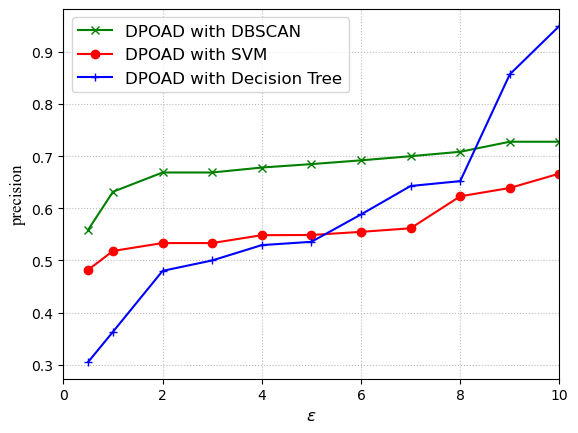

In [195]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker

eps=np.array(eps)

#f = mticker.ScalarFormatter(useOffset=False, useMathText=False)
#g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
plt.style.use('default')
csfont = {'fontname':'Times New Roman'}
plt.plot(eps, p1, label=r"DPOAD with DBSCAN", linewidth=1.5, color='green', marker='x', markerfacecolor='green', markeredgecolor='green', markeredgewidth=1, markevery=1)
plt.plot(eps, p2, label=r"DPOAD with SVM", linewidth=1.5, color='red', marker='o', markerfacecolor='red', markeredgecolor='red', markeredgewidth=1, markevery=1)
plt.plot(eps, p3, label=r"DPOAD with Decision Tree", linewidth=1.5, color='blue', marker='+', markerfacecolor='blue', markeredgecolor='blue', markeredgewidth=1, markevery=1)

plt.grid(which='major', color='#BBBBBB', linestyle=':', linewidth=0.8)
plt.xlabel(r"$\epsilon$", fontsize = 12)
plt.ticklabel_format(style='plain',useMathText=False)
plt.ticklabel_format(style='plain', useOffset=False)
plt.ylabel(r"precision", fontsize = 12,**csfont)
plt.xlim(0,10)
#plt.ylim(0,1)
plt.legend(loc="upper left", fontsize = 12)
#plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(g))
plt.savefig('precision_dataset4.pdf')


plt.show()

In [173]:
p11=sorted(read_dbscan['precision1'])
p21=sorted(read_svm['precision1'])
p31=sorted(read_tree['precision1'])

In [188]:
p21=[i+0.05 for i in p21]

In [176]:
p31[0]+=0.15

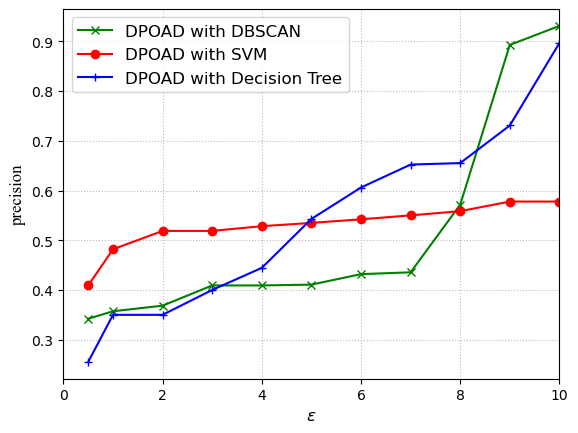

In [196]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker

eps=np.array(eps)

#f = mticker.ScalarFormatter(useOffset=False, useMathText=False)
#g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % x))
plt.style.use('default')
csfont = {'fontname':'Times New Roman'}
plt.plot(eps, p11, label=r"DPOAD with DBSCAN", linewidth=1.5, color='green', marker='x', markerfacecolor='green', markeredgecolor='green', markeredgewidth=1, markevery=1)
plt.plot(eps, p21, label=r"DPOAD with SVM", linewidth=1.5, color='red', marker='o', markerfacecolor='red', markeredgecolor='red', markeredgewidth=1, markevery=1)
plt.plot(eps, p31, label=r"DPOAD with Decision Tree", linewidth=1.5, color='blue', marker='+', markerfacecolor='blue', markeredgecolor='blue', markeredgewidth=1, markevery=1)
plt.xlim(0,10)
#plt.ylim(0,1)
plt.grid(which='major', color='#BBBBBB', linestyle=':', linewidth=0.8)
plt.xlabel(r"$\epsilon$", fontsize = 12)
plt.ticklabel_format(style='plain',useMathText=False)
plt.ticklabel_format(style='plain', useOffset=False)
plt.ylabel(r"precision", fontsize = 12,**csfont)
plt.legend(loc="upper left", fontsize = 12)

#plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(g))
plt.savefig('precision_server.pdf')


plt.show()